# A Conditional workflow model
Here we are attempting to create a conditional workflow model using a LLM. Where we try to find the roots of a quadratic equation.

### 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
# import operator

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

### 2. Linking the model

In [3]:
model = ChatOllama(model="gemma:2b")

### 3. Creating a schema for a structured output
As we are expecting a text feedback and a numerical score, the output needs to be structured. Using the BaseModel and Field from pydantic we can declare the structure in which the LLM will have to answer. 

In [4]:
class Evaluation_Schema(BaseModel):
    score : bool = Field(description="True if positive review, False if negative review")                   # Pydantic will make sure that the return type is true or false automatically.

class Diagnostics_Schema(BaseModel):
    issue_type: Literal["UI", "Performance", "Bug", "Support", "Other"] = Field(description = "The category in which the user is facing issues with")
    tone : Literal["Angry", "Frustrated", "Disappointed", "Calm", "Sarcastic"] = Field(description = "The emotional and verbal tone of the user")
    urgency : Literal["Low", "Medium", "High"] = Field(description = "The measure of urgency reflected by the review")

In [5]:
structured_model_1 = model.with_structured_output(Evaluation_Schema)

structured_model_2 = model.with_structured_output(Diagnostics_Schema)

### 4. Create a state

In [6]:
class ReviewState(TypedDict):                      # The ReviewState inherits a TypedDict
    review : str
    issue_type: Literal["UI", "Performance", "Bug", "Support", "Other"]
    tone : Literal["Angry", "Frustrated", "Disappointed", "Calm", "Sarcastic"]
    urgency : Literal["Low", "Medium", "High"]
    is_positive : bool
    response : str    

### 5. Define the function for the graph node

In [7]:
# Here instead of returning the entire state, we are returning partial updates in the form of dictionary items of the altered values only

def find_sentiment(state: ReviewState) -> ReviewState:
    prompt = f"Find the whether the following review is positive:\n\n\n{state["review"]}"
    output = structured_model_1.invoke(prompt)
    return {"is_positive" : output.score}


def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f"Find the issue domain, emotional tone and urgency portrayed by the user faced according to the following review:\n\n\n{state["review"]}"
    output = structured_model_2.invoke(prompt)

    return {"issue_type" : output.issue_type, "tone" : output.tone, "urgency" : output.urgency}


def negative_response(state: ReviewState) -> ReviewState:
    prompt = f"Appologise to the user regarding the issues faced by them in the {state["issue_type"]}, and try to console them according to the {state["tone"]} as mentioned in the following review:\n\n\n{state["review"]}"
    output = model.invoke(prompt)
    return {"response" : output.content}


def positive_response(state: ReviewState) -> ReviewState:
    prompt = f"Thank the customer, make them feel special"
    output = model.invoke(prompt)
    return {"response" : output.content}



### 6. Define the conditional function

In [8]:
def on_sentiment(state: ReviewState) -> Literal["run_diagnosis", "positive_response"]:
    if state["is_positive"] == True:
        return "positive_response"
    else:
        return "run_diagnosis"

### 7. Create the graph

In [9]:
# Declare the graph:
graph = StateGraph(ReviewState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)
graph.add_node("positive_response", positive_response)

# Add the sequential edges:
graph.add_edge(START, "find_sentiment")
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("positive_response", END)
graph.add_edge("negative_response", END)

# Add the conditional edges:
graph.add_conditional_edges("find_sentiment", on_sentiment)


### 8. Compile the graph

In [10]:
workflow = graph.compile()
type(workflow)

langgraph.graph.state.CompiledStateGraph

### 9. The Graph

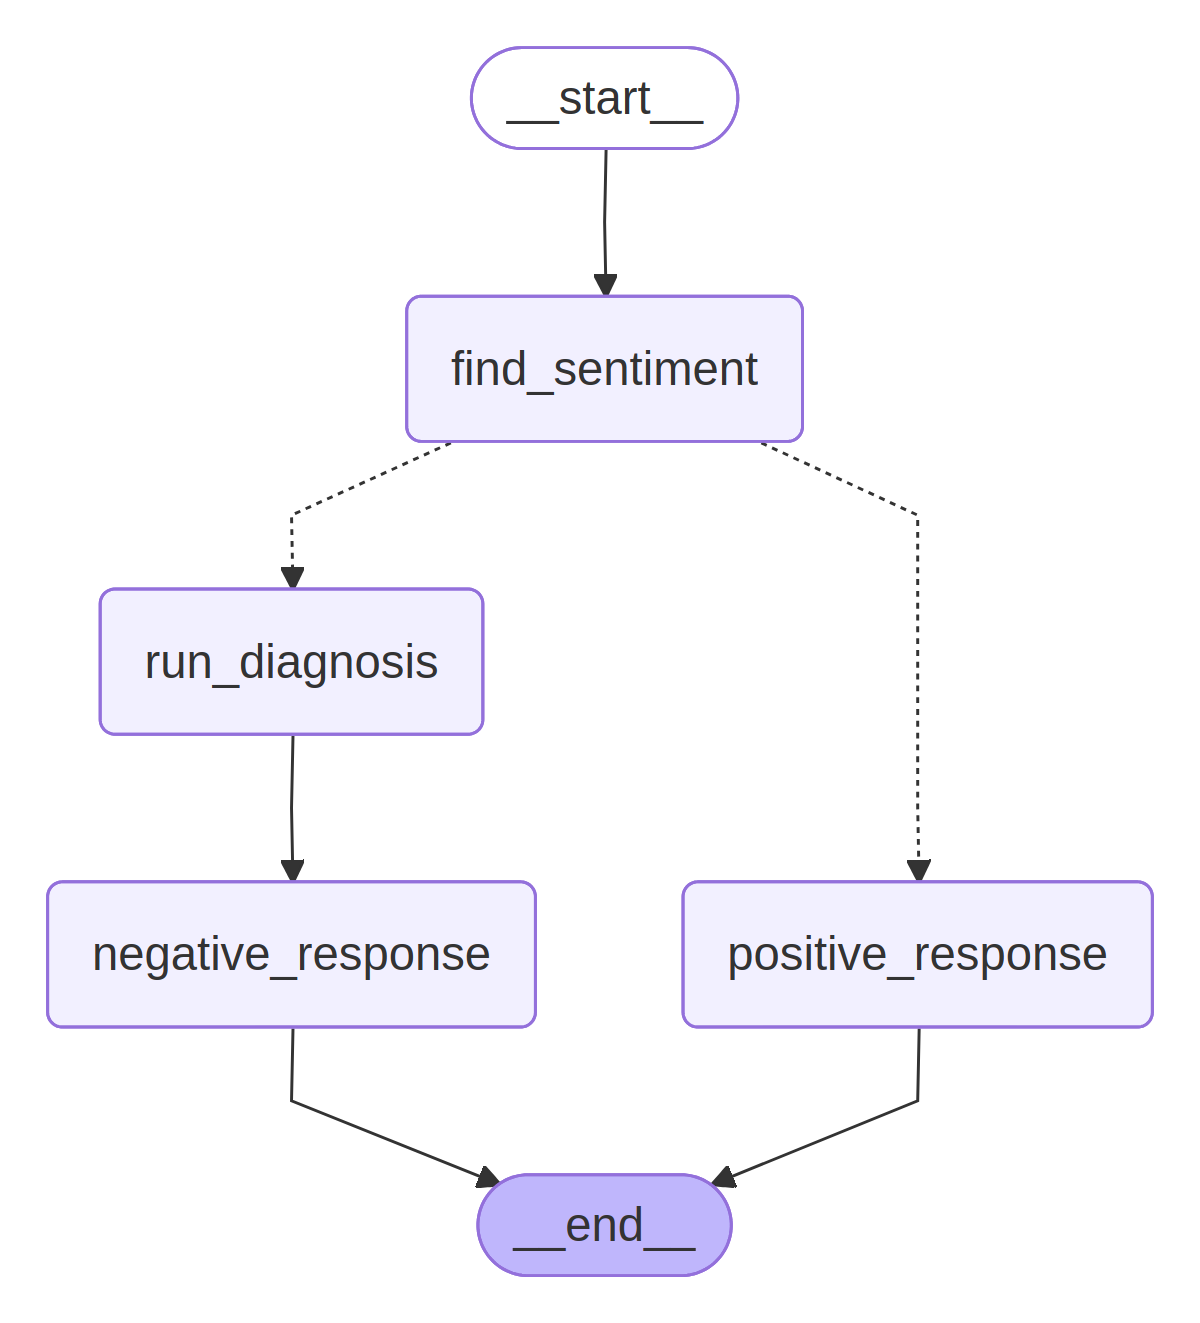

In [11]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

### 8. Run the code

In [12]:
review_1 = """I’ve been using OnePlus phones for a few years now, and they consistently deliver one of the best overall Android experiences in the market. The build quality feels premium without being overpriced, and the OxygenOS interface is fast, clean, and refreshingly bloat-free — something most brands still can’t get right.

Performance-wise, OnePlus phones never disappoint. Even after months of use, apps launch instantly, multitasking remains smooth, and battery optimization is top-notch. The displays are vibrant and sharp, making everything from gaming to media consumption a pleasure.

I also appreciate OnePlus’s commitment to regular software updates and community engagement — they actually listen to user feedback and implement changes that make a difference.

If you want a flagship experience without the excessive price tag or unnecessary gimmicks, OnePlus is one of the few brands that still focuses on speed, simplicity, and user satisfaction over hype."""

In [13]:
initial_state = {"review": review_1}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': 'I’ve been using OnePlus phones for a few years now, and they consistently deliver one of the best overall Android experiences in the market. The build quality feels premium without being overpriced, and the OxygenOS interface is fast, clean, and refreshingly bloat-free — something most brands still can’t get right.\n\nPerformance-wise, OnePlus phones never disappoint. Even after months of use, apps launch instantly, multitasking remains smooth, and battery optimization is top-notch. The displays are vibrant and sharp, making everything from gaming to media consumption a pleasure.\n\nI also appreciate OnePlus’s commitment to regular software updates and community engagement — they actually listen to user feedback and implement changes that make a difference.\n\nIf you want a flagship experience without the excessive price tag or unnecessary gimmicks, OnePlus is one of the few brands that still focuses on speed, simplicity, and user satisfaction over hype.', 'is_positive': Tr

In [14]:
print(final_state["response"])


Thank you for your patronage! It's my pleasure to assist you. I'm here to help make your experience a pleasant one, so please don't hesitate to let me know if you have any questions or concerns. 

Is there anything I can do for you today?


In [21]:
review_2 = """The OnePlus UI used to be one of the cleanest, fastest Android experiences out there. But the newer versions — since merging with Oppo’s ColorOS — feel cluttered, inconsistent, and bloated.

The old OxygenOS was lean and elegant; now it’s burdened with redundant settings, duplicate apps, and unnecessary visual noise. The simplicity that used to define OnePlus is gone. Transitions feel heavier, icons look cartoonish, and menus often require extra steps to reach options that were once straightforward.

It’s clear the design team is trying to mimic ColorOS aesthetics, but in the process, they’ve lost the functional coherence that made OxygenOS great. The result is a UI that looks modern on the surface but feels compromised underneath — a downgrade in both design philosophy and user experience."""

In [22]:
initial_state = {"review": review_2}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': 'The OnePlus UI used to be one of the cleanest, fastest Android experiences out there. But the newer versions — since merging with Oppo’s ColorOS — feel cluttered, inconsistent, and bloated.\n\nThe old OxygenOS was lean and elegant; now it’s burdened with redundant settings, duplicate apps, and unnecessary visual noise. The simplicity that used to define OnePlus is gone. Transitions feel heavier, icons look cartoonish, and menus often require extra steps to reach options that were once straightforward.\n\nIt’s clear the design team is trying to mimic ColorOS aesthetics, but in the process, they’ve lost the functional coherence that made OxygenOS great. The result is a UI that looks modern on the surface but feels compromised underneath — a downgrade in both design philosophy and user experience.', 'issue_type': 'UI', 'tone': 'Disappointed', 'urgency': 'High', 'is_positive': False, 'response': "**We sincerely apologize for the UI issues you've been experiencing.**\n\nThank yo

In [23]:
print(final_state["response"])

**We sincerely apologize for the UI issues you've been experiencing.**

Thank you for sharing your feedback and expressing your disappointment. We understand that the OnePlus UI has lost its clean and efficient look and feel in recent iterations.

We take your feedback seriously and are committed to addressing it. We understand that a well-designed UI is crucial for user satisfaction and overall experience.

We're aware that some of the recent changes we've made to the UI may have felt unnecessary or distracting. We understand that these changes may have overshadowed the simplicity and functionality that once defined the OnePlus experience.

We'd like to assure you that we're actively working to improve the UI and bring back the seamless and intuitive experience you're accustomed to. We're continuously testing and iterating on the UI, and we value your feedback in guiding our improvements.

We're eager to hear your thoughts on the latest UI changes and how we can further enhance the us

In [24]:
print(final_state["tone"])

Disappointed


In [25]:
print(final_state["issue_type"])

UI


In [26]:
print(final_state["urgency"])

High
